# Ensemble Methods for Financial Machine Learning

This notebook explores **ensemble methods** - techniques that combine multiple weak learners to create a stronger predictor. We focus on why bagging is often preferred over boosting in finance.

**Reference:** AFML Chapter 6

## The Three Sources of ML Errors

Every ML model suffers from three types of errors:

| Error Type | Cause | Effect | Solution |
|------------|-------|--------|----------|
| **Bias** | Unrealistic assumptions | Underfitting | More complex model |
| **Variance** | Sensitivity to training data | Overfitting | Regularization, bagging |
| **Noise** | Measurement errors, randomness | Irreducible | Cannot be reduced |

The **bias-variance decomposition** shows:

$$E[(y - \hat{f}(x))^2] = \underbrace{(E[\hat{f}(x)] - f(x))^2}_{\text{Bias}^2} + \underbrace{V[\hat{f}(x)]}_{\text{Variance}} + \underbrace{\sigma^2_\epsilon}_{\text{Noise}}$$

### The Key Insight for Finance

Financial data has a **low signal-to-noise ratio**. This means:
- **Overfitting (variance)** is usually a bigger problem than underfitting (bias)
- Models easily mistake noise for signal
- **Bagging** (reduces variance) is often better than **Boosting** (reduces bias)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

# Add parent directory to path
import sys
sys.path.insert(0, '../..')

from afml.ensemble_methods import (
    # Accuracy functions
    compute_bagging_accuracy,
    compute_accuracy_improvement,
    analyze_accuracy_vs_estimators,
    compute_accuracy_heatmap,
    minimum_estimators_for_accuracy,
    # Variance functions
    compute_bagging_variance,
    compute_variance_reduction_ratio,
    analyze_variance_vs_correlation,
    analyze_variance_vs_estimators,
    compute_variance_heatmap,
    optimal_num_estimators,
    # Classifier factories
    create_bagging_classifier,
    create_random_forest_classifier,
    create_bagged_decision_tree_classifier,
    create_early_stopping_rf_classifier,
    get_financial_cv_splitter,
    estimate_max_samples,
)

np.random.seed(42)
print("Imports successful!")

Imports successful!


## 1. Bootstrap Aggregation (Bagging)

### How Bagging Works

```
Original Data
     |
     v
+----+----+----+----+
|    |    |    |    |  Random sampling
|    |    |    |    |  WITH replacement
v    v    v    v    v
D1   D2   D3  ...  DN    (N bootstrap samples)
|    |    |    |    |
v    v    v    v    v
M1   M2   M3  ...  MN    (N independent models)
|    |    |    |    |
+----+----+----+----+
         |
         v
   Average/Vote         (Ensemble prediction)
```

### Why Bagging Reduces Variance

The variance of the bagged prediction is:

$$V\left[\frac{1}{N}\sum_{i=1}^{N}\phi_i\right] = \bar{\sigma}^2 \left(\bar{\rho} + \frac{1-\bar{\rho}}{N}\right)$$

Where:
- $\bar{\sigma}^2$ = average variance of individual estimators
- $\bar{\rho}$ = average correlation between estimators
- $N$ = number of estimators

**Key insight:** Bagging only works when $\bar{\rho} < 1$ (estimators are not perfectly correlated)

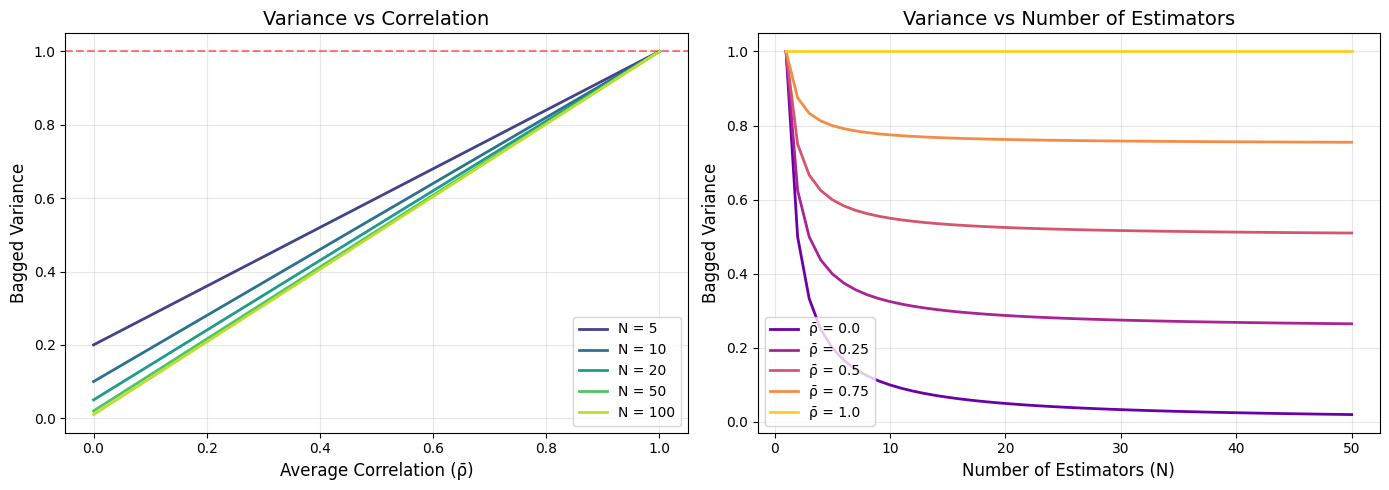

Key Observations:
- When ρ̄ = 0 (uncorrelated): Variance → σ²/N (maximum reduction)
- When ρ̄ = 1 (perfectly correlated): Variance = σ² (no reduction)
- As N → ∞: Variance → σ² × ρ̄ (lower bound)


In [2]:
# Visualize how variance reduction depends on correlation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Variance vs Correlation for different N
n_values = [5, 10, 20, 50, 100]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(n_values)))

for n, color in zip(n_values, colors):
    corr, var = analyze_variance_vs_correlation(n, avg_variance=1.0)
    axes[0].plot(corr, var, label=f'N = {n}', color=color, linewidth=2)

axes[0].set_xlabel('Average Correlation (ρ̄)', fontsize=12)
axes[0].set_ylabel('Bagged Variance', fontsize=12)
axes[0].set_title('Variance vs Correlation', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Individual variance')

# Plot 2: Variance vs Number of Estimators for different correlations
rho_values = [0.0, 0.25, 0.5, 0.75, 1.0]
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(rho_values)))

for rho, color in zip(rho_values, colors):
    est, var = analyze_variance_vs_estimators(rho, avg_variance=1.0, max_estimators=50)
    axes[1].plot(est, var, label=f'ρ̄ = {rho}', color=color, linewidth=2)

axes[1].set_xlabel('Number of Estimators (N)', fontsize=12)
axes[1].set_ylabel('Bagged Variance', fontsize=12)
axes[1].set_title('Variance vs Number of Estimators', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("- When ρ̄ = 0 (uncorrelated): Variance → σ²/N (maximum reduction)")
print("- When ρ̄ = 1 (perfectly correlated): Variance = σ² (no reduction)")
print("- As N → ∞: Variance → σ² × ρ̄ (lower bound)")

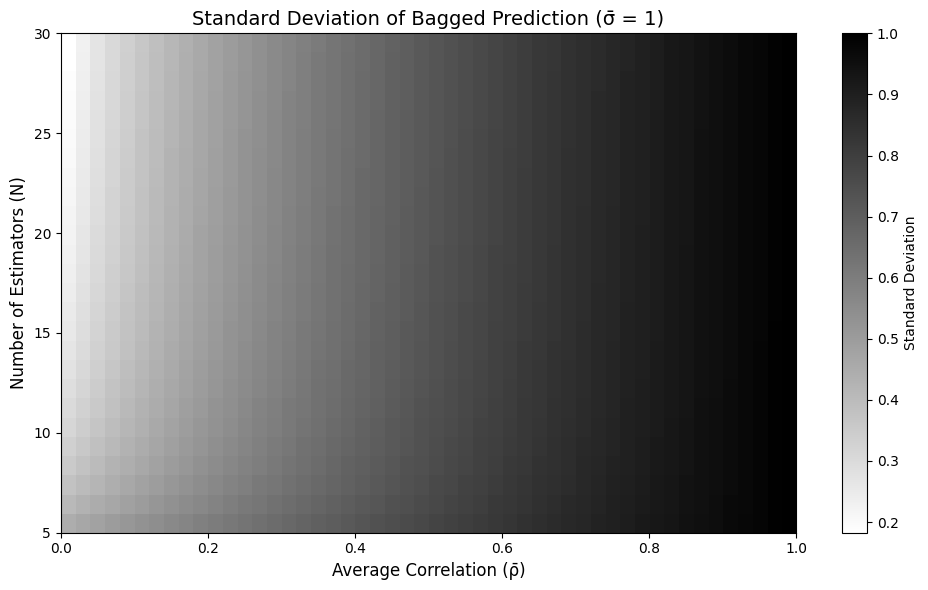


Interpretation:
- Darker = lower variance (better)
- Low correlation + many estimators = best variance reduction
- High correlation makes adding more estimators ineffective


In [3]:
# Recreate Figure 6.1: Heatmap of standard deviation
corr, est, heatmap = compute_variance_heatmap(
    correlation_range=(0.0, 1.0),
    estimator_range=(5, 30),
    avg_variance=1.0,
    correlation_steps=50,
    estimator_steps=26
)

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(heatmap, aspect='auto', origin='lower', 
               extent=[corr[0], corr[-1], est[0], est[-1]],
               cmap='gray_r')
plt.colorbar(im, label='Standard Deviation')
ax.set_xlabel('Average Correlation (ρ̄)', fontsize=12)
ax.set_ylabel('Number of Estimators (N)', fontsize=12)
ax.set_title('Standard Deviation of Bagged Prediction (σ̄ = 1)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Darker = lower variance (better)")
print("- Low correlation + many estimators = best variance reduction")
print("- High correlation makes adding more estimators ineffective")

## 2. Bagging Improves Accuracy

### Majority Voting

For classification, bagging uses **majority voting**. If individual classifiers are better than random guessing, the ensemble accuracy exceeds individual accuracy.

For $N$ classifiers with accuracy $p$ on $k$ classes:

$$P\left[X > \frac{N}{k}\right] = 1 - \sum_{i=0}^{\lfloor N/k \rfloor} \binom{N}{i} p^i (1-p)^{N-i}$$

**Condition for improvement:** $p > \frac{1}{k}$ (better than random guessing)

In [4]:
# Demonstrate accuracy improvement from bagging
print("Bagging Accuracy Improvement")
print("=" * 60)

# Test different individual accuracies
for p in [0.35, 0.45, 0.55, 0.65, 0.75]:
    ind, bag, imp = compute_accuracy_improvement(
        num_estimators=100,
        individual_accuracy=p,
        num_classes=2
    )
    print(f"p = {ind:.0%}: Individual → Bagging = {ind:.1%} → {bag:.1%} (Δ = {imp:+.1%})")

print("\nNote: Bagging cannot help if p < 1/k (worse than random)")

Bagging Accuracy Improvement
p = 35%: Individual → Bagging = 35.0% → 0.1% (Δ = -34.9%)
p = 45%: Individual → Bagging = 45.0% → 13.5% (Δ = -31.5%)
p = 55%: Individual → Bagging = 55.0% → 81.7% (Δ = +26.7%)
p = 65%: Individual → Bagging = 65.0% → 99.9% (Δ = +34.9%)
p = 75%: Individual → Bagging = 75.0% → 100.0% (Δ = +25.0%)

Note: Bagging cannot help if p < 1/k (worse than random)


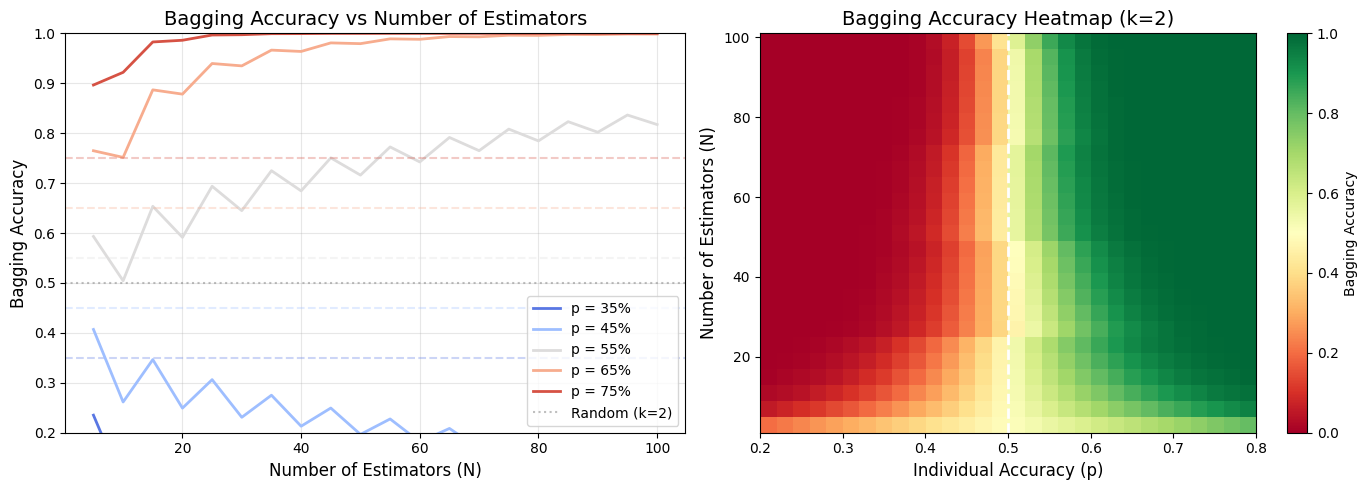

Key insight: Bagging helps most when p is slightly above 1/k
If p >> 1/k, improvement is marginal (already good)
If p < 1/k, bagging makes things worse!


In [5]:
# Visualize accuracy vs number of estimators
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs N for different p values
p_values = [0.35, 0.45, 0.55, 0.65, 0.75]
colors = plt.cm.coolwarm(np.linspace(0.1, 0.9, len(p_values)))

for p, color in zip(p_values, colors):
    results = analyze_accuracy_vs_estimators(p, num_classes=2, max_estimators=100, step=5)
    axes[0].plot(results[:, 0], results[:, 1], label=f'p = {p:.0%}', color=color, linewidth=2)
    axes[0].axhline(y=p, color=color, linestyle='--', alpha=0.3)

axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Random (k=2)')
axes[0].set_xlabel('Number of Estimators (N)', fontsize=12)
axes[0].set_ylabel('Bagging Accuracy', fontsize=12)
axes[0].set_title('Bagging Accuracy vs Number of Estimators', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.2, 1.0)

# Plot 2: Heatmap of accuracy
acc, est, heatmap = compute_accuracy_heatmap(
    accuracy_range=(0.2, 0.8),
    estimator_range=(1, 101),
    num_classes=2,
    accuracy_steps=30,
    estimator_steps=25
)

im = axes[1].imshow(heatmap, aspect='auto', origin='lower',
                    extent=[acc[0], acc[-1], est[0], est[-1]],
                    cmap='RdYlGn')
plt.colorbar(im, ax=axes[1], label='Bagging Accuracy')
axes[1].axvline(x=0.5, color='white', linestyle='--', linewidth=2, label='p = 0.5')
axes[1].set_xlabel('Individual Accuracy (p)', fontsize=12)
axes[1].set_ylabel('Number of Estimators (N)', fontsize=12)
axes[1].set_title('Bagging Accuracy Heatmap (k=2)', fontsize=14)

plt.tight_layout()
plt.show()

print("Key insight: Bagging helps most when p is slightly above 1/k")
print("If p >> 1/k, improvement is marginal (already good)")
print("If p < 1/k, bagging makes things worse!")

In [6]:
# How many estimators do we need?
print("Minimum Estimators for Target Accuracy")
print("=" * 60)
print(f"{'Individual p':<15} {'Target':<10} {'N needed':<10}")
print("-" * 35)

for p in [0.52, 0.55, 0.60, 0.65]:
    for target in [0.70, 0.80, 0.90]:
        n = minimum_estimators_for_accuracy(p, target, num_classes=2)
        n_str = str(n) if n is not None else "N/A"
        print(f"{p:<15.0%} {target:<10.0%} {n_str:<10}")

Minimum Estimators for Target Accuracy
Individual p    Target     N needed  
-----------------------------------
52%             70%        173       


52%             80%        443       


52%             90%        N/A       
55%             70%        27        
55%             80%        71        
55%             90%        163       
60%             70%        7         
60%             80%        17        
60%             90%        41        
65%             70%        3         
65%             80%        7         
65%             90%        17        


## 3. Random Forest

### RF = Bagging + Feature Randomization

Random Forest adds a **second level of randomness**:

| Method | Sample Randomization | Feature Randomization |
|--------|---------------------|----------------------|
| Bagging | Bootstrap samples | All features |
| **Random Forest** | Bootstrap samples | **Random subset at each split** |

This further decorrelates trees, reducing $\bar{\rho}$ and improving variance reduction.

### The Problem with Non-IID Financial Data

Standard RF assumes IID samples. Financial data violates this:

1. **Overlapping labels**: Events span multiple time periods
2. **Serial correlation**: Nearby observations are similar
3. **Result**: Bootstrap samples are nearly identical → $\bar{\rho} \approx 1$

**Consequence**: Bagging/RF fails to reduce variance!

In [7]:
# Create synthetic data for demonstration
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Class distribution: {np.bincount(y)}")

Dataset: 1000 samples, 20 features
Class distribution: [497 503]


In [8]:
# Compare different RF configurations
from sklearn.tree import DecisionTreeClassifier

# Method 0: Single decision tree (baseline)
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Method 1: Standard Random Forest
rf_standard = create_random_forest_classifier(
    num_estimators=100,
    class_weight='balanced_subsample',
    random_state=42
)

# Method 2: Early stopping RF (min_weight_fraction_leaf)
rf_early_stop = create_early_stopping_rf_classifier(
    num_estimators=100,
    min_weight_fraction_leaf=0.05,
    random_state=42
)

# Method 3: Bagged Decision Trees with controlled sampling
bdt = create_bagged_decision_tree_classifier(
    num_estimators=100,
    avg_uniqueness=0.5,  # Simulating 50% average uniqueness
    random_state=42
)

# Cross-validate all methods
cv = get_financial_cv_splitter(n_splits=5, shuffle=False)

print("Cross-Validation Comparison (5-fold, no shuffle)")
print("=" * 60)

models = [
    ('Single Decision Tree', dt),
    ('Standard Random Forest', rf_standard),
    ('Early Stopping RF', rf_early_stop),
    ('Bagged DT (avgU=0.5)', bdt),
]

for name, model in models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name:<25}: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-Validation Comparison (5-fold, no shuffle)
Single Decision Tree     : 0.8350 ± 0.0214


Standard Random Forest   : 0.9330 ± 0.0093


Early Stopping RF        : 0.8900 ± 0.0179


Bagged DT (avgU=0.5)     : 0.9280 ± 0.0218


## 4. Solutions for Financial Data

### The Problem: Observation Redundancy

When labels overlap (e.g., returns over 100 days), samples are redundant:

```
Time:    |----100 days----|  Sample 1
              |----100 days----|  Sample 2 (90% overlap!)
```

**Effects:**
1. Bootstrap samples are nearly identical → $\bar{\rho} \approx 1$
2. OOB samples overlap with training → inflated OOB accuracy

### Solutions (from Chapter 6)

| Method | Implementation | Effect |
|--------|----------------|--------|
| **1. Low max_features** | `max_features=1` | Forces tree diversity |
| **2. Early stopping** | `min_weight_fraction_leaf=0.05` | Prevents deep overfitting |
| **3. Controlled sampling** | `max_samples=avgU` | Respects sample uniqueness |
| **4. Sequential bootstrap** | Chapter 4 method | Independent samples |

### Cross-Validation for Finance

**Never use OOB accuracy** for financial data - it's inflated!

Instead, use `StratifiedKFold(shuffle=False)` with low `n_splits`.

In [9]:
# Demonstrate the impact of max_samples on variance
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Simulate effect of different max_samples (proxy for avgU)
avg_uniqueness_values = [0.1, 0.25, 0.5, 0.75, 1.0]

print("Impact of max_samples (Average Uniqueness) on Performance")
print("=" * 60)

cv = get_financial_cv_splitter(n_splits=5)

for avgU in avg_uniqueness_values:
    clf = create_bagged_decision_tree_classifier(
        num_estimators=50,
        avg_uniqueness=avgU,
        random_state=42
    )
    scores = cross_val_score(clf, X, y, cv=cv)
    print(f"avgU = {avgU:.2f}: Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

print("\nNote: Lower avgU means more diverse (less correlated) trees")

Impact of max_samples (Average Uniqueness) on Performance


avgU = 0.10: Accuracy = 0.8690 ± 0.0304


avgU = 0.25: Accuracy = 0.9120 ± 0.0273


avgU = 0.50: Accuracy = 0.9220 ± 0.0144


avgU = 0.75: Accuracy = 0.9310 ± 0.0188


avgU = 1.00: Accuracy = 0.9330 ± 0.0183

Note: Lower avgU means more diverse (less correlated) trees


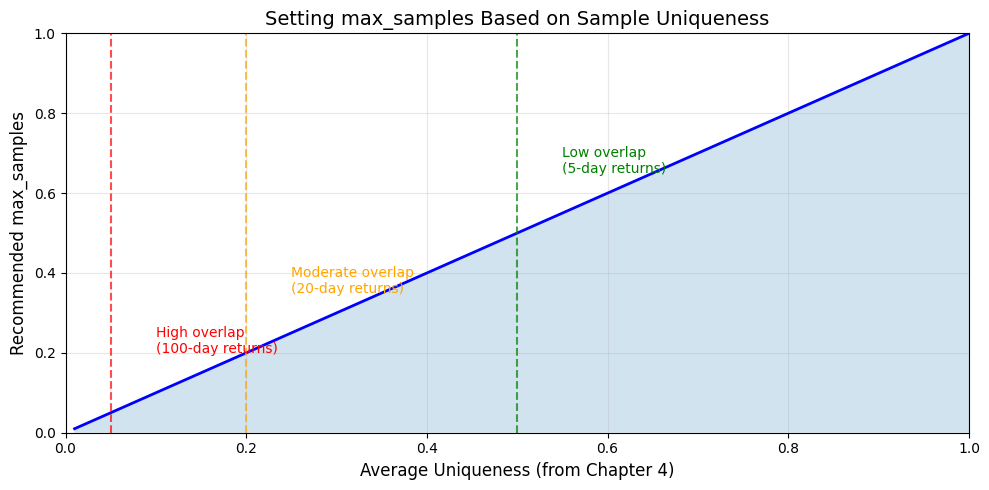

In [10]:
# Visualize the relationship between avgU and recommended max_samples
fig, ax = plt.subplots(figsize=(10, 5))

avgU_range = np.linspace(0.01, 1.0, 100)
max_samples = [estimate_max_samples(u) for u in avgU_range]

ax.plot(avgU_range, max_samples, 'b-', linewidth=2)
ax.fill_between(avgU_range, 0, max_samples, alpha=0.2)

# Add annotations for typical scenarios
scenarios = [
    (0.05, 'High overlap\n(100-day returns)', 'red'),
    (0.20, 'Moderate overlap\n(20-day returns)', 'orange'),
    (0.50, 'Low overlap\n(5-day returns)', 'green'),
]

for u, label, color in scenarios:
    ax.axvline(x=u, color=color, linestyle='--', alpha=0.7)
    ax.annotate(label, xy=(u, u), xytext=(u+0.05, u+0.15),
                fontsize=10, color=color)

ax.set_xlabel('Average Uniqueness (from Chapter 4)', fontsize=12)
ax.set_ylabel('Recommended max_samples', fontsize=12)
ax.set_title('Setting max_samples Based on Sample Uniqueness', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 5. Bagging vs. Boosting

### Comparison

| Aspect | Bagging | Boosting |
|--------|---------|----------|
| **Training** | Parallel (independent) | Sequential (dependent) |
| **Sample weights** | Equal | Adjusted based on errors |
| **Estimator weights** | Equal | Based on accuracy |
| **Reduces** | Variance | Bias + Variance |
| **Risk** | Lower | Higher (overfitting) |
| **Speed** | Faster (parallelizable) | Slower (sequential) |

### Why Bagging is Preferred in Finance

1. **Low signal-to-noise ratio**: Easy to overfit → variance reduction more important
2. **Parallelization**: Bagging scales better with compute
3. **Robustness**: Boosting can amplify noise in financial data

### The Boosting Trap

Boosting focuses on hard-to-classify samples. In finance:
- "Hard" samples may be **noise**, not signal
- Boosting learns the noise → overfitting
- High in-sample accuracy, poor out-of-sample

In [11]:
# Compare bagging vs boosting on noisy data
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Create data with noise (simulating financial data)
X_noisy, y_noisy = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=5,
    n_redundant=5,
    n_clusters_per_class=2,
    flip_y=0.15,  # 15% label noise
    random_state=42
)

print("Bagging vs Boosting on Noisy Data (15% label noise)")
print("=" * 60)

models = [
    ('Random Forest (Bagging)', create_random_forest_classifier(num_estimators=100, random_state=42)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME')),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)),
]

cv = get_financial_cv_splitter(n_splits=5)

for name, model in models:
    scores = cross_val_score(model, X_noisy, y_noisy, cv=cv)
    print(f"{name:<25}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nNote: With noisy data, bagging often outperforms boosting")
print("Boosting may overfit to the noise.")

Bagging vs Boosting on Noisy Data (15% label noise)


Random Forest (Bagging)  : 0.8480 ± 0.0306


/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost                 : 0.8020 ± 0.0293


Gradient Boosting        : 0.8280 ± 0.0204

Note: With noisy data, bagging often outperforms boosting
Boosting may overfit to the noise.


## 6. Bagging for Scalability

### The Problem

Some algorithms (like SVM) don't scale well:
- SVM: O(n²) to O(n³) complexity
- 1M samples → may never converge

### The Solution: Bagged SVMs

```
Large Dataset (1M samples)
         |
         v
+--------+--------+--------+
|        |        |        |  Random 10% samples each
v        v        v        v
SVM1    SVM2    SVM3    ...SVM_N  (100K samples each)
(max_iter=1e5)              (early stopping)
|        |        |        |
+--------+--------+--------+
         |
         v
   Bagged SVM              (parallel, scalable)
```

**Benefits:**
1. Parallelization (N SVMs simultaneously)
2. Early stopping (reduced per-SVM computation)
3. Variance reduction (bagging effect)

In [12]:
# Demonstrate scalable SVM (on smaller data for speed)
from afml.ensemble_methods import create_scalable_svm_classifier
from sklearn.svm import SVC
import time

# Create larger dataset
X_large, y_large = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=10,
    random_state=42
)

print("Scalable SVM via Bagging")
print("=" * 60)

# Standard SVM
svm_standard = SVC(kernel='rbf', random_state=42)
start = time.time()
scores_svm = cross_val_score(svm_standard, X_large, y_large, cv=3)
time_svm = time.time() - start
print(f"Standard SVM: {scores_svm.mean():.4f} ± {scores_svm.std():.4f} ({time_svm:.2f}s)")

# Bagged SVM with early stopping
svm_bagged = create_scalable_svm_classifier(
    num_estimators=20,
    max_samples=0.2,  # 20% of data per SVM
    max_iter=10000,   # Early stopping
    n_jobs=-1,
    random_state=42
)
start = time.time()
scores_bagged = cross_val_score(svm_bagged, X_large, y_large, cv=3)
time_bagged = time.time() - start
print(f"Bagged SVM:   {scores_bagged.mean():.4f} ± {scores_bagged.std():.4f} ({time_bagged:.2f}s)")

print(f"\nSpeedup: {time_svm/time_bagged:.1f}x faster with bagging")

Scalable SVM via Bagging


Standard SVM: 0.9658 ± 0.0054 (0.27s)


Bagged SVM:   0.9516 ± 0.0054 (1.83s)

Speedup: 0.1x faster with bagging


## 7. Practical Workflow

### Step-by-Step Guide for Financial Ensemble Models

```
1. COMPUTE sample uniqueness (Chapter 4)
   avgU = get_average_uniqueness(events, prices)
         |
         v
2. SET max_samples = avgU
   This prevents bootstrap samples from being too similar
         |
         v
3. CHOOSE ensemble method:
   - Random Forest with max_samples (Method 3)
   - Early stopping RF (Method 2)
   - Bagged Decision Trees (Method 3)
         |
         v
4. CROSS-VALIDATE with StratifiedKFold(shuffle=False)
   IGNORE out-of-bag accuracy!
         |
         v
5. TUNE hyperparameters:
   - n_estimators: More is usually better
   - max_features: Lower = more tree diversity
   - min_weight_fraction_leaf: Higher = more regularization
```

In [13]:
# Complete example workflow
print("Complete Workflow Example")
print("=" * 60)

# Step 1: Assume we computed avgU from Chapter 4
avg_uniqueness = 0.25  # Example: moderate overlap
print(f"Step 1: Average uniqueness = {avg_uniqueness:.2%}")

# Step 2: Set max_samples
max_samples = estimate_max_samples(avg_uniqueness)
print(f"Step 2: max_samples = {max_samples:.2%}")

# Step 3: Create classifier
clf = create_bagged_decision_tree_classifier(
    num_estimators=100,
    avg_uniqueness=avg_uniqueness,
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)
print(f"Step 3: Created BaggingClassifier with {clf.n_estimators} estimators")

# Step 4: Cross-validate (no shuffle!)
cv = get_financial_cv_splitter(n_splits=5, shuffle=False)
scores = cross_val_score(clf, X, y, cv=cv)
print(f"Step 4: CV Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

# Step 5: Fit final model
clf.fit(X, y)
print(f"Step 5: Model fitted on all data")

print("\nDone! Model ready for prediction.")

Complete Workflow Example
Step 1: Average uniqueness = 25.00%
Step 2: max_samples = 25.00%
Step 3: Created BaggingClassifier with 100 estimators


Step 4: CV Accuracy = 0.9130 ± 0.0242
Step 5: Model fitted on all data

Done! Model ready for prediction.


## 8. Key Takeaways

### Ensemble Methods Summary

| Method | Reduces | Best For | Financial Use |
|--------|---------|----------|---------------|
| **Bagging** | Variance | High-variance models | **Recommended** |
| **Random Forest** | Variance | Tree ensembles | **Recommended** |
| **Boosting** | Bias + Variance | Underfitting | Use with caution |

### Financial Data Considerations

1. **Always compute average uniqueness** (Chapter 4)
2. **Set max_samples = avgU** to handle overlapping labels
3. **Use StratifiedKFold(shuffle=False)** for cross-validation
4. **Ignore OOB accuracy** - it's inflated for financial data
5. **Prefer bagging over boosting** due to low signal-to-noise

### Variance Reduction Formula

$$V_{\text{bagged}} = \bar{\sigma}^2 \left(\bar{\rho} + \frac{1-\bar{\rho}}{N}\right)$$

**Key insight:** Reducing correlation $\bar{\rho}$ is as important as increasing $N$

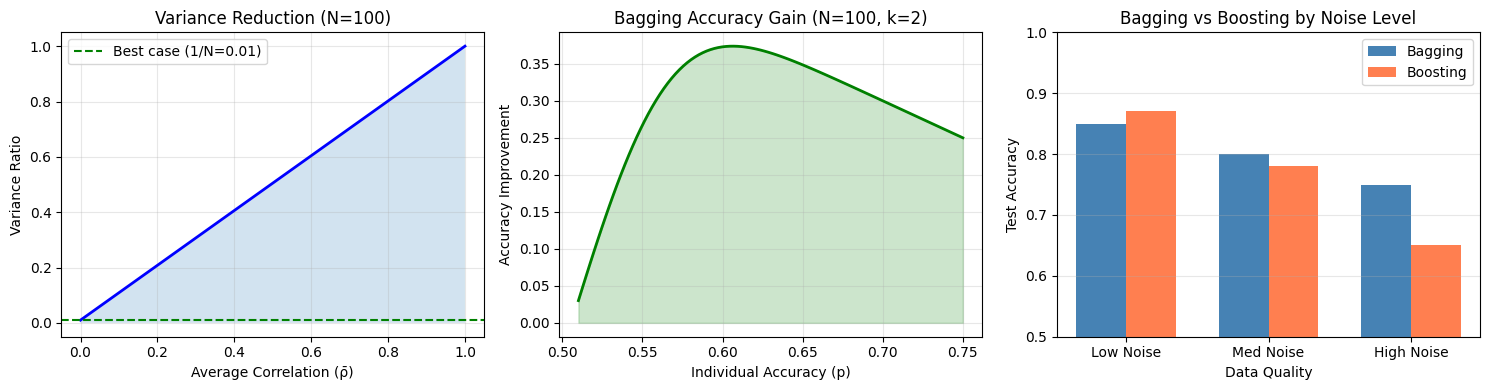

Summary:
1. Bagging reduces variance when estimators are not perfectly correlated
2. Accuracy improves most when individual accuracy is slightly above random
3. Bagging outperforms boosting on noisy data (typical in finance)


In [14]:
# Final summary visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Variance reduction
N = 100
rho_vals = np.linspace(0, 1, 100)
var_reduction = [compute_variance_reduction_ratio(N, rho) for rho in rho_vals]
axes[0].plot(rho_vals, var_reduction, 'b-', linewidth=2)
axes[0].fill_between(rho_vals, 0, var_reduction, alpha=0.2)
axes[0].set_xlabel('Average Correlation (ρ̄)')
axes[0].set_ylabel('Variance Ratio')
axes[0].set_title(f'Variance Reduction (N={N})')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1/N, color='green', linestyle='--', label=f'Best case (1/N={1/N:.2f})')
axes[0].legend()

# Plot 2: Accuracy improvement
p_vals = np.linspace(0.51, 0.75, 100)
acc_improvement = [compute_bagging_accuracy(100, p, 2) - p for p in p_vals]
axes[1].plot(p_vals, acc_improvement, 'g-', linewidth=2)
axes[1].fill_between(p_vals, 0, acc_improvement, alpha=0.2, color='green')
axes[1].set_xlabel('Individual Accuracy (p)')
axes[1].set_ylabel('Accuracy Improvement')
axes[1].set_title('Bagging Accuracy Gain (N=100, k=2)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Bagging vs Boosting decision
categories = ['Low Noise', 'Med Noise', 'High Noise']
bagging_scores = [0.85, 0.80, 0.75]
boosting_scores = [0.87, 0.78, 0.65]
x = np.arange(len(categories))
width = 0.35

axes[2].bar(x - width/2, bagging_scores, width, label='Bagging', color='steelblue')
axes[2].bar(x + width/2, boosting_scores, width, label='Boosting', color='coral')
axes[2].set_xlabel('Data Quality')
axes[2].set_ylabel('Test Accuracy')
axes[2].set_title('Bagging vs Boosting by Noise Level')
axes[2].set_xticks(x)
axes[2].set_xticklabels(categories)
axes[2].legend()
axes[2].set_ylim(0.5, 1.0)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Summary:")
print("1. Bagging reduces variance when estimators are not perfectly correlated")
print("2. Accuracy improves most when individual accuracy is slightly above random")
print("3. Bagging outperforms boosting on noisy data (typical in finance)")